### Installation

Create a new conda env, and install pytorch, torchvision first (make sure they're compatiable with your cuda version). Then install sam and groundingdino.

```shell
python -m pip install -e segment_anything
python -m pip install -e GroundingDINO
pip install diffusers transformers accelerate scipy safetensors
```

In [1]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

In [2]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


If there's warning ""Failed to load custom C++ ops. Running on CPU mode Only!"

For groundingdino cuda inference, please follow this [link](https://github.com/IDEA-Research/Grounded-Segment-Anything/issues/15)

Or try:
```shell
cd GroundingDINO
python setup.py build
python setup.py install
```

Then download backbone weight for SAM (Run for once).

In [ ]:
!mkdir ckpt
os.chdir('ckpt')
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

You could skip the below parts and read **Frames Mask Convert** part.

### Inference Step by Step

#### Load Grounding DINO

Grounding DINO is used to receive text prompt and give SAM a knowledge prior.

In [3]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [4]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/jingmin/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


#### Load SAM

In [6]:
sam_checkpoint = 'ckpt/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

#### Load Image

In [7]:
import io

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)
local_image_path = 'assets/raw data/Dataset/bouquet/bouquet/images/frame_00001.jpg'

#### Run Grounding DINO for Detection with Text Prompt

In [8]:
# define text guidance
TEXT_PROMPT = "bouquet"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

In [10]:
image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


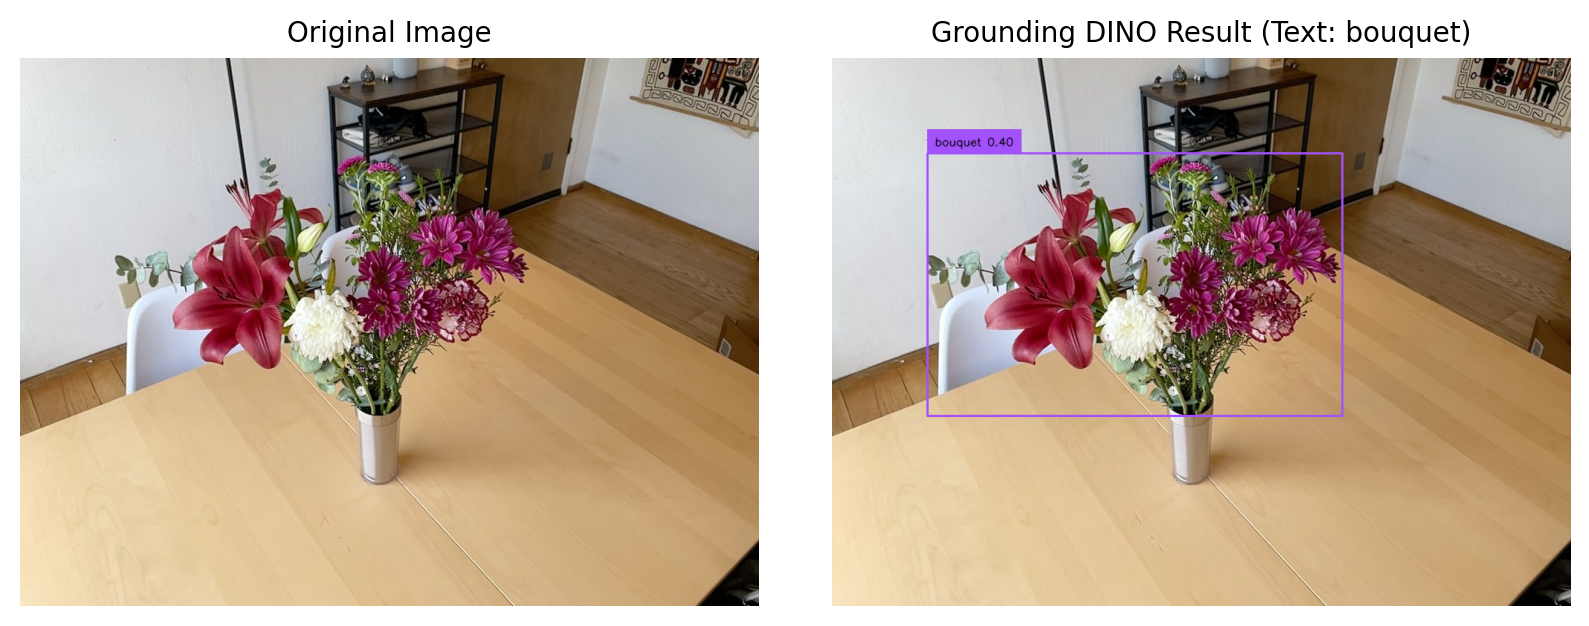

In [11]:
# Image.fromarray(image_source)
# Image.fromarray(annotated_frame)

plt.figure(figsize=(10, 5), dpi=200)

plt.subplot(1, 2, 1)
plt.imshow(image_source)
plt.title("Original Image", fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(annotated_frame)
plt.title("Grounding DINO Result (Text: {})".format(TEXT_PROMPT), fontsize=10)
plt.axis('off')
plt.subplots_adjust(wspace=0.1)

plt.show()

#### Run SAM with Grounding DINO Knowledge Prior

In [12]:
# set image
sam_predictor.set_image(image_source)
# box from groundingdino: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [13]:
# SAM inference
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )

In [14]:
print('Original image shape:', image_source.shape)
print('SAM masks shape:', masks.shape)

Original image shape: (738, 994, 3)
SAM masks shape: torch.Size([1, 1, 738, 994])


In [15]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    if type(mask) == torch.Tensor:
        mask = mask.cpu().numpy()
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    if type(mask_image) == torch.Tensor:
        mask_image = mask_image.cpu().numpy()
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [16]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

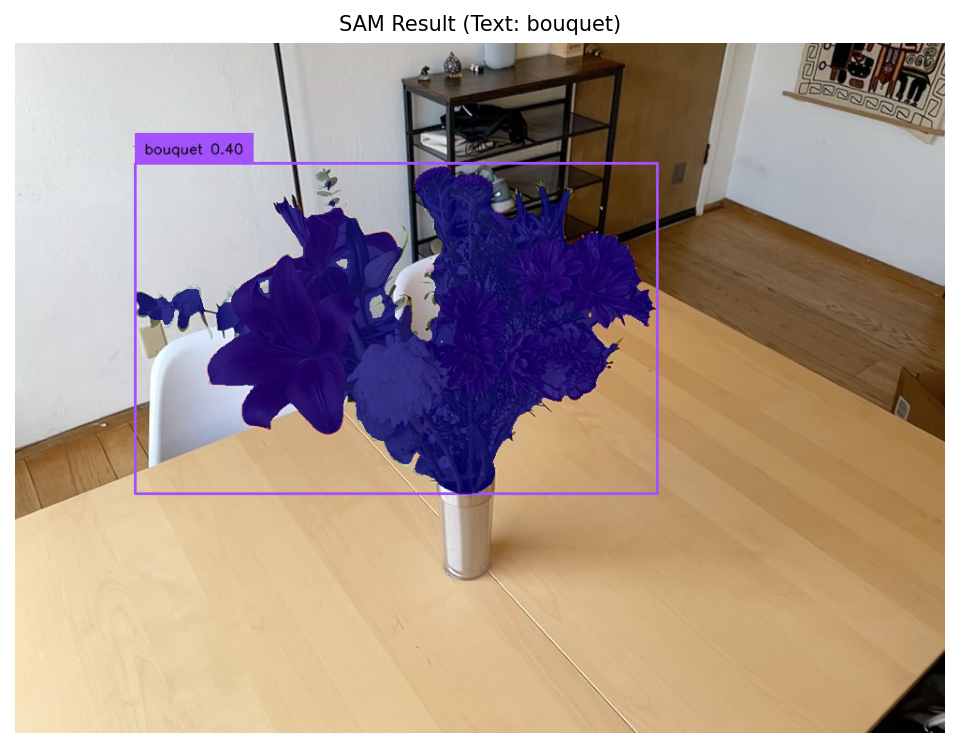

In [17]:
plt.figure(figsize=(8, 6), dpi=150)

plt.imshow(annotated_frame_with_mask)
plt.title("SAM Result (Text: {})".format(TEXT_PROMPT), fontsize=10)
plt.axis('off')

plt.show()

#### Masks

In [18]:
image_mask = masks[0][0].cpu().numpy()
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

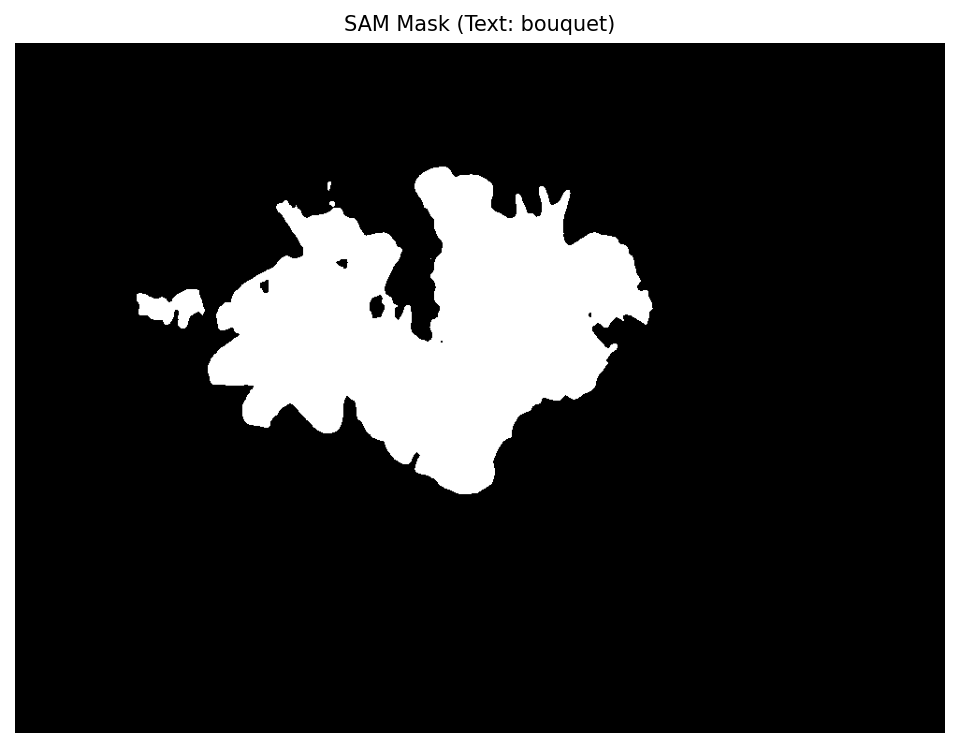

In [19]:
plt.figure(figsize=(8, 6), dpi=150)

plt.imshow(image_mask_pil)
plt.title("SAM Mask (Text: {})".format(TEXT_PROMPT), fontsize=10)
plt.axis('off')

plt.show()

### Frames Mask Convert

In [3]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [4]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    if type(mask) == torch.Tensor:
        mask = mask.cpu().numpy()
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    if type(mask_image) == torch.Tensor:
        mask_image = mask_image.cpu().numpy()
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [5]:
# user-defined text prompt
TEXT_PROMPT = "bouquet"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

In [6]:
# ckpt for groundingdino
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/jingmin/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [7]:
# ckpt for sam, remember to download the ckpt file first
sam_checkpoint = 'ckpt/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

In [8]:
def predict_with_GroundedSAM(image_path, sam_predictor, groundingdino_model, text_prompt, box_threshold, text_threshold):
    image_source, image = load_image(image_path)

    # Grounding DINO inference
    boxes, logits, phrases = predict(
        model=groundingdino_model, 
        image=image, 
        caption=text_prompt, 
        box_threshold=box_threshold, 
        text_threshold=text_threshold
    ) 

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

    sam_predictor.set_image(image_source)
    # box from groundingdino: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

    # SAM inference
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)

    try:
        masks, _, _ = sam_predictor.predict_torch(
                    point_coords = None,
                    point_labels = None,
                    boxes = transformed_boxes,
                    multimask_output = False,
                )
    except RuntimeError as e:
        # print(f"No segmented target when processing {image_path}:\n {e}")
        # create a full false mask
        masks = torch.zeros((1, 1, H, W), dtype=torch.bool)
    
    annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

    # mask image
    image_mask = masks[0][0].cpu().numpy()
    image_mask = image_mask.astype(np.uint8) * 255 # from logistic to 01
    # image_source_pil = Image.fromarray(image_source)
    # annotated_frame_pil = Image.fromarray(annotated_frame)
    # image_mask_pil = Image.fromarray(image_mask)
    # annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)
    
    return image_source, annotated_frame, image_mask, annotated_frame_with_mask

In [10]:
# process one frame
# frame 167 has problems (no segmented target)
local_image_path = 'assets/raw data/Dataset/bouquet/bouquet/images/frame_00001.jpg'
image_source, annotated_frame, image_mask, annotated_frame_with_mask = \
    predict_with_GroundedSAM(local_image_path, sam_predictor, groundingdino_model, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)

print(image_mask.shape)
print(image_mask)

# save as jpg
image = Image.fromarray(image_mask.astype('uint8'), 'L')
os.makedirs('assets/raw data/Dataset/bouquet/bouquet/masks', exist_ok=True)
image.save('assets/raw data/Dataset/bouquet/bouquet/masks/test.jpg')

/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


(738, 994)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


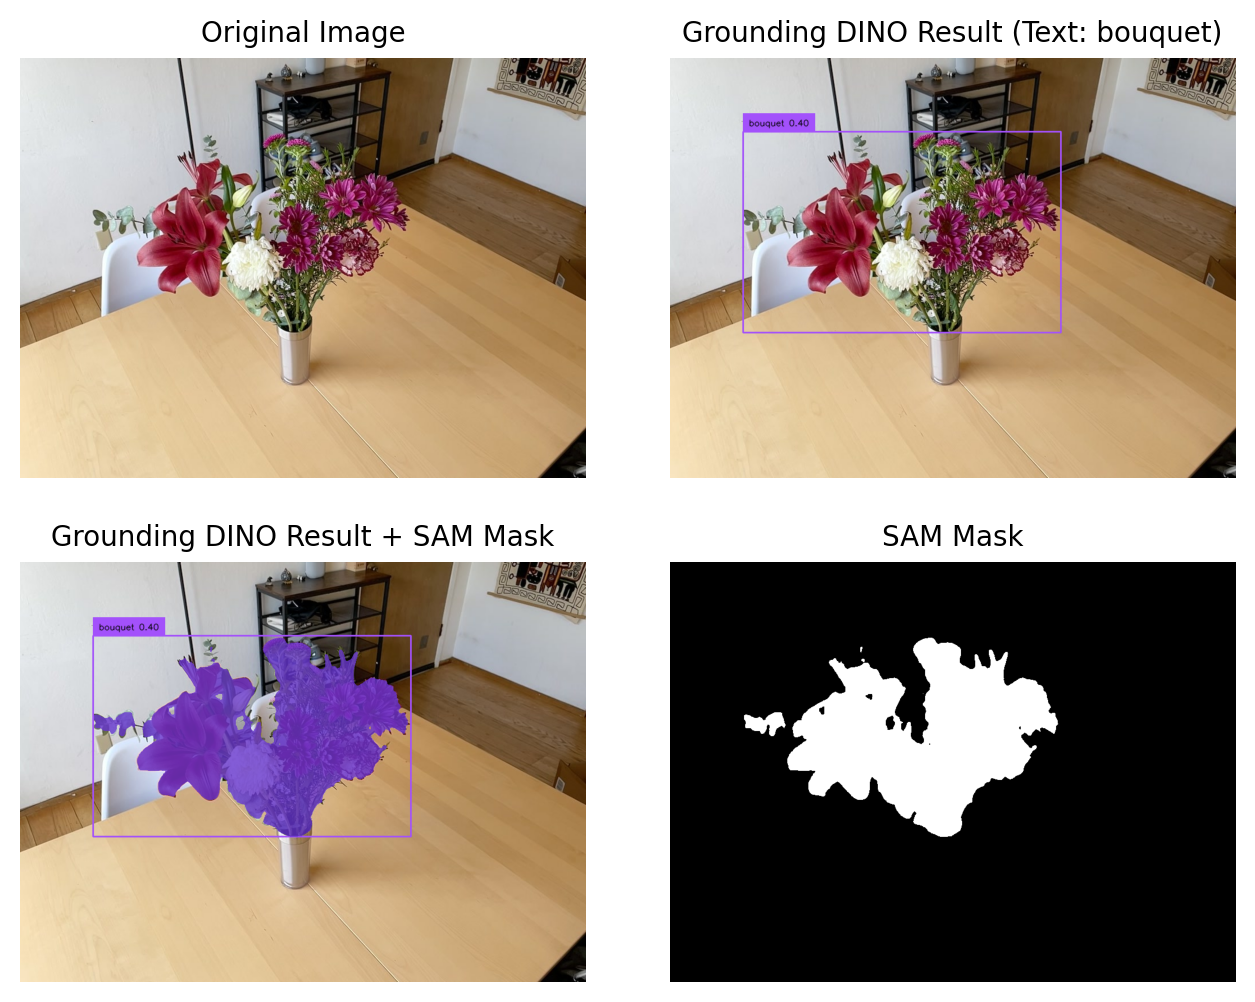

In [11]:
# visualization
plt.figure(figsize=(8, 6), dpi=200)

plt.subplot(2, 2, 1)
plt.imshow(image_source)
plt.title("Original Image", fontsize=10)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(annotated_frame)
plt.title("Grounding DINO Result (Text: {})".format(TEXT_PROMPT), fontsize=10)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(annotated_frame_with_mask)
plt.title("Grounding DINO Result + SAM Mask", fontsize=10)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(image_mask, cmap='gray')
plt.title("SAM Mask", fontsize=10)
plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.show()

In [12]:
from tqdm import tqdm

def process_frames(input_frames_path, output_masks_path, sam_predictor, groundingdino_model, text_prompt, box_threshold, text_threshold):
    frame_files = [f for f in os.listdir(input_frames_path) if f.endswith('.jpg')]

    frame_files.sort()

    for frame_file in tqdm(frame_files, desc="Processing Frames"):
        frame_path = os.path.join(input_frames_path, frame_file)
        
        # forward inference, get image_mask
        _, _, image_mask, _ = predict_with_GroundedSAM(frame_path, sam_predictor, groundingdino_model, text_prompt, box_threshold, text_threshold)

        mask_file = frame_file.replace('frame', 'mask')
        mask_path = os.path.join(output_masks_path, mask_file)

        # print(frame_path, mask_path)

        mask_saved = Image.fromarray(image_mask.astype('uint8'), 'L')
        mask_saved.save(mask_path)

Now you could generate masks by simply define your own dataset and the text prompt. Here's an example for dataset Bouquet.

In [24]:
# user-defined dataset
local_dataset_path = 'assets/raw data/Dataset/bouquet/bouquet/' # change this to your own dataset path
# local_dataset_path = 'assets/raw data/Dataset/teatime/teatime/'
local_image_path = os.path.join(local_dataset_path, 'images/frame_00001.jpg')
local_farmes_path = os.path.join(local_dataset_path, 'images/')
output_masks_path = os.path.join(local_dataset_path, 'masks/')
os.makedirs(os.path.join(local_dataset_path, 'masks'), exist_ok=True)

# user-defined text prompt
TEXT_PROMPT = "bouquet" # change this to your own text prompt
# TEXT_PROMPT = "cup"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

In [25]:
process_frames(local_farmes_path, output_masks_path, sam_predictor, groundingdino_model, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)

Processing Frames:   0%|          | 0/180 [00:00<?, ?it/s]/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/jingmin/anaconda3/envs/sam/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Processing Frames:  79%|███████▉  | 143/180 [01:33<00:24,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00143.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  80%|████████  | 144/180 [01:33<00:23,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00144.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  82%|████████▏ | 147/180 [01:35<00:21,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00147.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  83%|████████▎ | 149/180 [01:37<00:20,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00149.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  85%|████████▌ | 153/180 [01:39<00:17,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00153.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  86%|████████▌ | 154/180 [01:40<00:17,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00154.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  86%|████████▌ | 155/180 [01:41<00:16,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00155.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  87%|████████▋ | 156/180 [01:41<00:15,  1.52it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00156.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  89%|████████▉ | 161/180 [01:44<00:12,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00161.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  90%|█████████ | 162/180 [01:45<00:11,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00162.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  92%|█████████▏| 165/180 [01:47<00:09,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00165.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  92%|█████████▏| 166/180 [01:48<00:09,  1.53it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00166.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames:  99%|█████████▉| 178/180 [01:56<00:01,  1.52it/s]

No segmented target when processing assets/raw data/Dataset/teatime/teatime/images/frame_00178.jpg:
 cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous


Processing Frames: 100%|██████████| 180/180 [01:57<00:00,  1.53it/s]


#### Change transforms.json

First, make sure source image, generated mask image, and style image are the same size.

In [29]:
# choose one local image
image_source, image = load_image(local_image_path)
print('Image source shape:', image_source.shape)
H, W, _ = image_source.shape
# define style image
os.makedirs(os.path.join(local_dataset_path, 'style_images'), exist_ok=True)
style_image_path = os.path.join(local_dataset_path, 'style_images/starry.jpg')
style_name, file_extension = os.path.splitext(os.path.basename(style_image_path))

dataset_name = os.path.basename(local_dataset_path.rstrip('/'))

print('Dataset name:', dataset_name)
print('Style name:', style_name)

Image source shape: (738, 994, 3)
Dataset name: teatime
Style name: starry


In [30]:
img = Image.open(local_image_path)
print('image shape:', img.size)

mask_path = os.path.join(local_dataset_path, 'masks/mask_00001.jpg')
mask_img = Image.open(mask_path)
print('Mask image shape:', mask_img.size)

image shape: (994, 738)
Mask image shape: (994, 738)


In [32]:
# make sure their size is the same
style_image = Image.open(style_image_path)
style_image_resized = style_image.resize((W, H))
output_file_name = '{}_reshape.jpg'.format(style_name)
output_file_path = os.path.join(os.path.dirname(style_image_path), output_file_name)
style_image_resized.save(output_file_path)
print('Style image new shape:', style_image_resized.size)

Style image new shape: (994, 738)


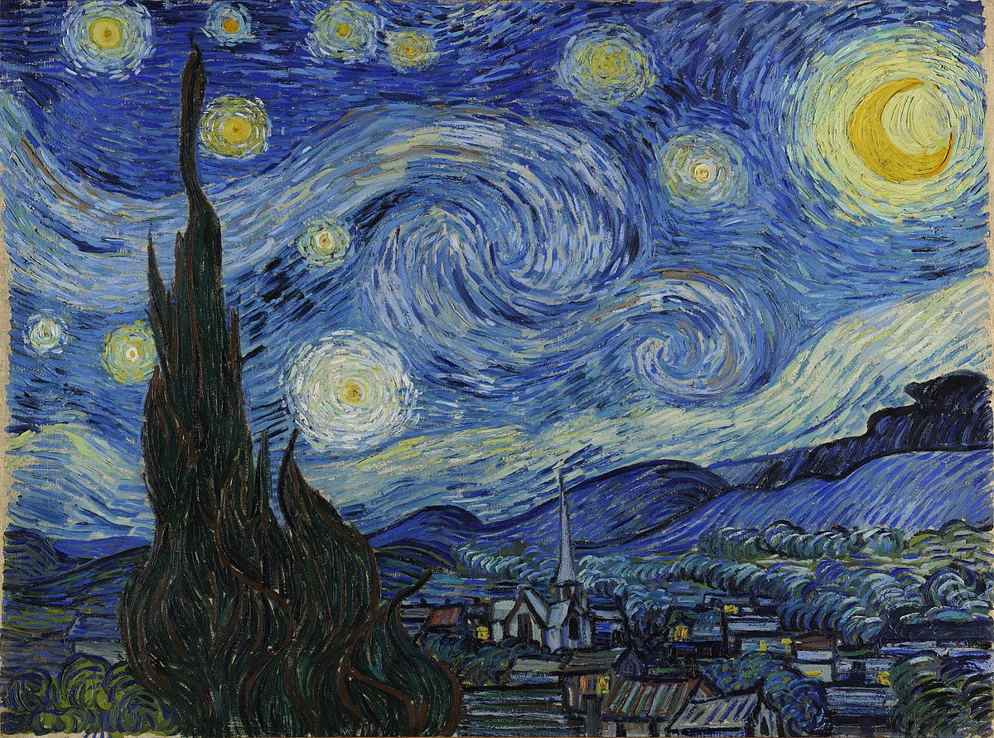

In [33]:
style_image_resized

In new `transforms_{dataset_name}_{style_name}.json`, for every frame, Keep the `file_path` the same (which is the path to style image), and add the local mask path to `mask_path` for every frame.

In [34]:
import json

original_json_path = os.path.join(local_dataset_path, 'transforms.json')
new_json_path = os.path.join(local_dataset_path, 'transforms_{}_{}.json'.format(dataset_name, style_name))

with open(original_json_path, 'r') as file:
    data = json.load(file)

for frame in data['frames']:
    original_file_name = frame['file_path'].split('/')[-1]
    mask_file_name = original_file_name.replace('frame', 'mask')
    # change mask_path to masks
    frame['mask_path'] = f"./masks/{mask_file_name}"
    # change file_path to one same style image
    frame['file_path'] = f"./style_images/{style_name}_reshape.jpg"

with open(new_json_path, 'w') as file:
    json.dump(data, file, indent=4)

Then you could use the new json and also the style image to train the model.